In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

# Load the correct dataset
train_df = pd.read_parquet("train_time_based.parquet")

train_df.head(), train_df.shape


(    userId  n_events  n_active_days  n_unique_pages  n_sessions  \
 0  1000035      1054             17              15          16   
 1  1000103        75              3              10           3   
 2  1000164       644             12              16          11   
 3  1000168       617              7              14           6   
 4  1000182       433              7              12           4   
 
    events_per_day  recency_days  account_age_days  last_level  target  ...  \
 0       62.000000             1                58           1       0  ...   
 1       25.000000             1                48           1       0  ...   
 2       53.666667             0                89           1       0  ...   
 3       88.142857             1                93           1       0  ...   
 4       61.857143             0               129           1       0  ...   
 
    n_upgrade  n_submit_downgrade  n_settings  n_about  n_error  \
 0        5.0                 0.0         6.0  

In [24]:
X = train_df.drop(columns=["userId", "target", "last_level"])
y = train_df["target"]

print(X.shape, y.shape)
print(y.value_counts())



(15276, 18) (15276,)
target
0    14613
1      663
Name: count, dtype: int64


In [25]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_val.shape


((12220, 18), (3056, 18))

In [ ]:
# Calculer scale_pos_weight pour gérer le déséquilibre
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

# Version améliorée avec early stopping et meilleurs hyperparamètres
try:
    xgb = XGBClassifier(
        n_estimators=1000,  # Plus d'arbres
        max_depth=5,  # Légèrement réduit pour éviter l'overfitting
        learning_rate=0.01,  # Learning rate plus bas pour plus de stabilité
        subsample=0.85,
        colsample_bytree=0.85,
        min_child_weight=3,  # Contrôle l'overfitting
        gamma=0.1,  # Régularisation supplémentaire
        reg_alpha=0.1,  # L1 regularization
        reg_lambda=1.0,  # L2 regularization
        scale_pos_weight=scale_pos_weight,  # Gestion du déséquilibre
        eval_metric="auc",  # Utiliser AUC comme métrique
        early_stopping_rounds=50,  # Early stopping dans l'initialisation (nouvelle API)
        use_label_encoder=False,
        random_state=42,
        tree_method="hist"  # Plus rapide
    )
except TypeError:
    # Version sans paramètres optionnels pour compatibilité
    try:
        xgb = XGBClassifier(
            n_estimators=1000,
            max_depth=5,
            learning_rate=0.01,
            subsample=0.85,
            colsample_bytree=0.85,
            min_child_weight=3,
            gamma=0.1,
            reg_alpha=0.1,
            reg_lambda=1.0,
            scale_pos_weight=scale_pos_weight,
            eval_metric="auc",
            early_stopping_rounds=50,
            random_state=42
        )
    except TypeError:
        # Version très basique sans early stopping dans l'init
        xgb = XGBClassifier(
            n_estimators=1000,
            max_depth=5,
            learning_rate=0.01,
            subsample=0.85,
            colsample_bytree=0.85,
            min_child_weight=3,
            gamma=0.1,
            reg_alpha=0.1,
            reg_lambda=1.0,
            scale_pos_weight=scale_pos_weight,
            eval_metric="auc",
            random_state=42
        )

# Utiliser early stopping avec validation set
try:
    xgb.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=100
    )
except Exception as e:
    print(f"⚠️ Erreur avec eval_set: {e}")
    print("Entraînement sans validation set...")
    xgb.fit(X_train, y_train)
    
print("✅ XGBoost trained!")


Scale pos weight: 22.06
[0]	validation_0-auc:0.63649
[100]	validation_0-auc:0.69176


/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [20:43:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[127]	validation_0-auc:0.69140
✅ XGBoost trained!


In [ ]:
import joblib

joblib.dump(xgb, "xgb_time_based.pkl")
print("✅ Model saved to xgb_time_based.pkl")


✅ Model saved to xgb_time_based.pkl


In [ ]:
y_val_proba = xgb.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_val_proba)

print("🔥 AUC validation:", auc)


🔥 AUC validation: 0.6929022865065503


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

thresholds = np.arange(0.0, 1.0, 0.01)
results = []

for t in thresholds:
    preds = (y_val_proba >= t).astype(int)
    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    prec = precision_score(y_val, preds, zero_division=0)
    rec = recall_score(y_val, preds)
    results.append({
        'threshold': t,
        'accuracy': acc,
        'f1': f1,
        'precision': prec,
        'recall': rec,
        'n_positives': preds.sum()
    })

results_df = pd.DataFrame(results)

# Meilleur seuil selon F1 (plus adapté au déséquilibre)
best_t_f1 = results_df.loc[results_df['f1'].idxmax(), 'threshold']
best_f1 = results_df['f1'].max()

# Meilleur seuil selon accuracy
best_t_acc = results_df.loc[results_df['accuracy'].idxmax(), 'threshold']
best_acc = results_df['accuracy'].max()

print("🔥 Meilleur seuil selon F1-score:", best_t_f1)
print("   F1-score:", best_f1)
print("   Prédictions positives:", int(results_df.loc[results_df['f1'].idxmax(), 'n_positives']))
print("\n📊 Meilleur seuil selon Accuracy:", best_t_acc)
print("   Accuracy:", best_acc)
print("   Prédictions positives:", int(results_df.loc[results_df['accuracy'].idxmax(), 'n_positives']))

# Afficher les métriques pour quelques seuils clés
print("\n📋 Métriques pour différents seuils:")
for t in [0.2, 0.3, 0.4, 0.5, 0.6]:
    row = results_df.iloc[(results_df['threshold'] - t).abs().idxmin()]
    print(f"  Seuil {t:.1f}: F1={row['f1']:.3f}, Prec={row['precision']:.3f}, Rec={row['recall']:.3f}, Pos={int(row['n_positives'])}")


🔥 Meilleur seuil selon F1-score: 0.56
   F1-score: 0.17280453257790368
   Prédictions positives: 573

📊 Meilleur seuil selon Accuracy: 0.68
   Accuracy: 0.956479057591623
   Prédictions positives: 0

📋 Métriques pour différents seuils:
  Seuil 0.2: F1=0.083, Prec=0.044, Rec=1.000, Pos=3056
  Seuil 0.3: F1=0.087, Prec=0.045, Rec=0.992, Pos=2914
  Seuil 0.4: F1=0.114, Prec=0.061, Rec=0.797, Pos=1732
  Seuil 0.5: F1=0.145, Prec=0.082, Rec=0.609, Pos=986
  Seuil 0.6: F1=0.122, Prec=0.099, Rec=0.158, Pos=212


Feature importance:


,feature,importance
3,n_sessions,0.194491
2,n_unique_pages,0.138196
1,n_active_days,0.096937
14,n_unique_songs,0.051096
0,n_events,0.047221
4,events_per_day,0.044103
6,account_age_days,0.041959
17,most_active_hour,0.041649
13,n_songs_played,0.040832
10,n_settings,0.038423


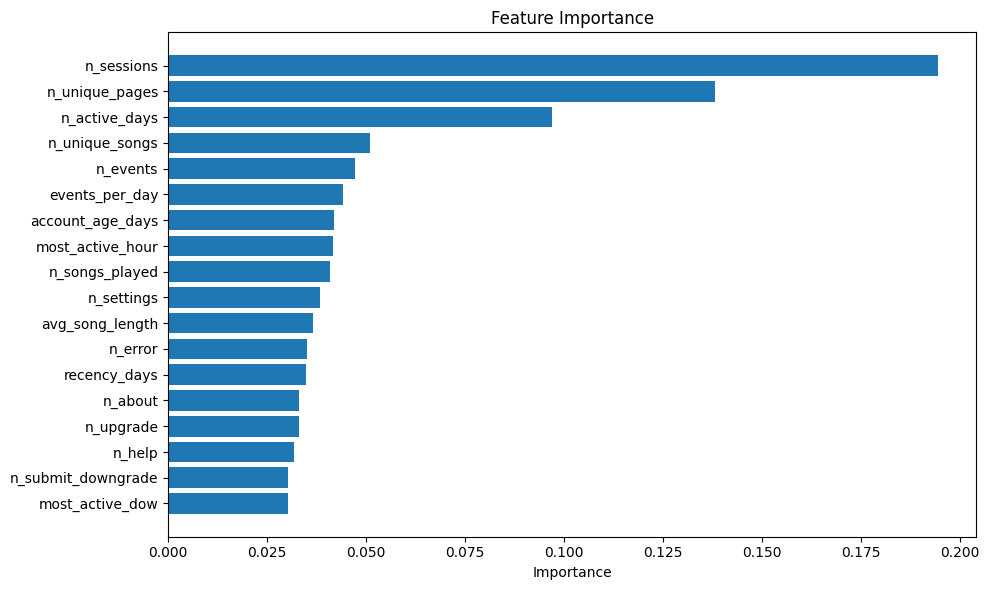

In [ ]:
# Analyser l'importance des features
import matplotlib.pyplot as plt

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature importance:")
display(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



In [31]:
# Comparer différentes configurations pour trouver la meilleure
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

configs = [
    {
        "name": "Config actuelle améliorée",
        "params": {
            "n_estimators": 1000,
            "max_depth": 5,
            "learning_rate": 0.01,
            "subsample": 0.85,
            "colsample_bytree": 0.85,
            "min_child_weight": 3,
            "gamma": 0.1,
            "reg_alpha": 0.1,
            "reg_lambda": 1.0,
            "scale_pos_weight": scale_pos_weight,
            "eval_metric": "auc",
            "use_label_encoder": False,
            "random_state": 42,
            "tree_method": "hist"
        }
    },
    {
        "name": "Config plus agressive",
        "params": {
            "n_estimators": 1500,
            "max_depth": 6,
            "learning_rate": 0.008,
            "subsample": 0.9,
            "colsample_bytree": 0.9,
            "min_child_weight": 2,
            "gamma": 0.05,
            "reg_alpha": 0.05,
            "reg_lambda": 0.5,
            "scale_pos_weight": scale_pos_weight,
            "eval_metric": "auc",
            "use_label_encoder": False,
            "random_state": 42,
            "tree_method": "hist"
        }
    },
    {
        "name": "Config plus conservative",
        "params": {
            "n_estimators": 800,
            "max_depth": 4,
            "learning_rate": 0.015,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "min_child_weight": 5,
            "gamma": 0.2,
            "reg_alpha": 0.2,
            "reg_lambda": 1.5,
            "scale_pos_weight": scale_pos_weight,
            "eval_metric": "auc",
            "use_label_encoder": False,
            "random_state": 42,
            "tree_method": "hist"
        }
    }
]

results_comparison = []

for config in configs:
    print(f"\n{'='*60}")
    print(f"Test de: {config['name']}")
    print(f"{'='*60}")
    
    # Gérer early_stopping_rounds selon la version de XGBoost
    params = config['params'].copy()
    
    # Dans les nouvelles versions, early_stopping_rounds doit être dans l'init
    # Essayer d'abord avec early_stopping dans l'init
    try:
        if 'early_stopping_rounds' not in params:
            params['early_stopping_rounds'] = 50
        model = XGBClassifier(**params)
        # Ne pas passer early_stopping_rounds dans fit()
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
    except TypeError:
        # Ancienne API ou paramètres non supportés
        params.pop('early_stopping_rounds', None)
        params.pop('use_label_encoder', None)
        params.pop('tree_method', None)
        model = XGBClassifier(**params)
        try:
            # Essayer avec early_stopping dans fit() (ancienne API)
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                early_stopping_rounds=50,
                verbose=False
            )
        except Exception:
            # Sans early stopping
            model.fit(X_train, y_train, verbose=False)
    
    y_val_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_proba)
    
    # Trouver le meilleur seuil pour F1
    thresholds = np.arange(0.0, 1.0, 0.01)
    best_f1 = 0
    best_thresh = 0
    for t in thresholds:
        preds = (y_val_proba >= t).astype(int)
        f1 = f1_score(y_val, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t
    
    preds_best = (y_val_proba >= best_thresh).astype(int)
    prec = precision_score(y_val, preds_best, zero_division=0)
    rec = recall_score(y_val, preds_best)
    
    results_comparison.append({
        "config": config['name'],
        "auc": auc,
        "best_f1": best_f1,
        "best_threshold": best_thresh,
        "precision": prec,
        "recall": rec,
        "n_positives": preds_best.sum()
    })
    
    print(f"AUC: {auc:.4f}")
    print(f"F1 (seuil {best_thresh:.2f}): {best_f1:.4f}")
    print(f"Precision: {prec:.4f}, Recall: {rec:.4f}")

# Afficher le résumé
print(f"\n{'='*60}")
print("RÉSUMÉ DES CONFIGURATIONS")
print(f"{'='*60}")
results_df = pd.DataFrame(results_comparison)
results_df = results_df.sort_values("auc", ascending=False)
display(results_df)

# Sauvegarder le meilleur modèle
best_config_idx = results_df.index[0]
best_model_name = results_df.loc[best_config_idx, "config"]
print(f"\n🏆 Meilleure configuration: {best_model_name}")
print(f"   AUC: {results_df.loc[best_config_idx, 'auc']:.4f}")
print(f"   F1: {results_df.loc[best_config_idx, 'best_f1']:.4f}")



Test de: Config actuelle améliorée


/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [20:44:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


AUC: 0.6929
F1 (seuil 0.56): 0.1728
Precision: 0.1065, Recall: 0.4586

Test de: Config plus agressive


/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [20:44:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


AUC: 0.6860
F1 (seuil 0.54): 0.1736
Precision: 0.1036, Recall: 0.5338

Test de: Config plus conservative
AUC: 0.6925
F1 (seuil 0.52): 0.1699
Precision: 0.1043, Recall: 0.4586

RÉSUMÉ DES CONFIGURATIONS


/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [20:44:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


,config,auc,best_f1,best_threshold,precision,recall,n_positives
0,Config actuelle améliorée,0.692902,0.172805,0.56,0.106457,0.458647,573
2,Config plus conservative,0.692542,0.169916,0.52,0.104274,0.458647,585
1,Config plus agressive,0.685970,0.173594,0.54,0.103650,0.533835,685



🏆 Meilleure configuration: Config actuelle améliorée
   AUC: 0.6929
   F1: 0.1728


In [33]:
# Entraîner le meilleur modèle et le sauvegarder
# Utiliser la configuration qui a donné le meilleur AUC

# ⚠️ CHOIX IMPORTANT : Sur quel dataset entraîner le modèle final ?
# Option 1: Entraîner sur TOUT le dataset (X, y) = train + val
#   ✅ Avantages: Plus de données = meilleur modèle en général
#   ✅ On a déjà validé que le modèle ne surapprend pas trop
#   ✅ Pour la soumission finale, on veut utiliser toutes les données
#   ⚠️ Inconvénient: On ne peut plus évaluer sur val (mais on l'a déjà fait)
#
# Option 2: Garder le modèle entraîné seulement sur train (X_train, y_train)
#   ✅ Plus conservateur
#   ✅ On garde val pour une dernière évaluation
#   ⚠️ Inconvénient: Moins de données d'entraînement

TRAIN_ON_FULL_DATASET = True  # Mettre à False pour entraîner seulement sur train

best_model_name = results_df.iloc[0]["config"]
# Trouver l'index dans configs
best_config_idx = next(i for i, c in enumerate(configs) if c["name"] == best_model_name)
best_params = configs[best_config_idx]['params']

print(f"Entraînement du modèle final avec: {best_model_name}")
print(f"AUC attendu: {results_df.iloc[0]['auc']:.4f}")

if TRAIN_ON_FULL_DATASET:
    print("\n📊 Entraînement sur TOUT le dataset (train + val)")
    X_final = X
    y_final = y
    eval_set_final = [(X_val, y_val)]  # On garde val pour le monitoring
else:
    print("\n📊 Entraînement seulement sur TRAIN (plus conservateur)")
    X_final = X_train
    y_final = y_train
    eval_set_final = [(X_val, y_val)]  # Val pour évaluation
    
# Filtrer les paramètres non supportés
final_params = best_params.copy()

# Gérer early_stopping_rounds selon la version
try:
    if 'early_stopping_rounds' not in final_params:
        final_params['early_stopping_rounds'] = 50
    xgb_final = XGBClassifier(**final_params)
    # Ne pas passer early_stopping_rounds dans fit()
    xgb_final.fit(
        X_final, y_final,
        eval_set=eval_set_final,
        verbose=100
    )
except TypeError:
    # Retirer les paramètres optionnels
    final_params.pop('early_stopping_rounds', None)
    final_params.pop('use_label_encoder', None)
    final_params.pop('tree_method', None)
    xgb_final = XGBClassifier(**final_params)
    try:
        # Essayer avec early_stopping dans fit() (ancienne API)
        xgb_final.fit(
            X_final, y_final,
            eval_set=eval_set_final,
            early_stopping_rounds=50,
            verbose=100
        )
    except Exception as e:
        print(f"⚠️ Erreur: {e}")
        print("Entraînement sans early stopping...")
        xgb_final.fit(X_final, y_final)

# Évaluer sur validation (seulement si on n'a pas entraîné sur val)
if TRAIN_ON_FULL_DATASET:
    print("\n⚠️ ATTENTION: Le modèle a été entraîné sur train + val")
    print("   L'évaluation sur val serait biaisée (le modèle a déjà vu ces données)")
    print("   On utilise le score de validation obtenu AVANT l'entraînement final")
    print(f"   AUC attendu (non biaisé): {results_df.iloc[0]['auc']:.4f}")
    
    # Optionnel: on peut quand même évaluer mais c'est biaisé
    y_val_proba_final = xgb_final.predict_proba(X_val)[:, 1]
    auc_final = roc_auc_score(y_val, y_val_proba_final)
    print(f"   AUC sur val (BIASÉ - à ne pas utiliser): {auc_final:.4f}")
    print("   ⚠️ Ce score est optimiste car le modèle a été entraîné sur val")
else:
    # Si on entraîne seulement sur train, on peut évaluer honnêtement sur val
    print("\n✅ Évaluation honnête sur validation (modèle entraîné seulement sur train)")
    y_val_proba_final = xgb_final.predict_proba(X_val)[:, 1]
    auc_final = roc_auc_score(y_val, y_val_proba_final)
    print(f"   AUC validation: {auc_final:.4f}")

# Sauvegarder
joblib.dump(xgb_final, "xgb_time_based.pkl")
print("\n✅ Modèle sauvegardé dans xgb_time_based.pkl")


Entraînement du modèle final avec: Config actuelle améliorée
AUC attendu: 0.6929

📊 Entraînement sur TOUT le dataset (train + val)
[0]	validation_0-auc:0.73542


/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xgboost/callback.py:386: UserWarning: [20:48:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-auc:0.79696
[200]	validation_0-auc:0.81960
[300]	validation_0-auc:0.84204
[400]	validation_0-auc:0.86055
[500]	validation_0-auc:0.88046
[600]	validation_0-auc:0.89896
[700]	validation_0-auc:0.91689
[800]	validation_0-auc:0.92992
[900]	validation_0-auc:0.94189
[999]	validation_0-auc:0.95375

⚠️ ATTENTION: Le modèle a été entraîné sur train + val
   L'évaluation sur val serait biaisée (le modèle a déjà vu ces données)
   On utilise le score de validation obtenu AVANT l'entraînement final
   AUC attendu (non biaisé): 0.6929
   AUC sur val (BIASÉ - à ne pas utiliser): 0.9537
   ⚠️ Ce score est optimiste car le modèle a été entraîné sur val

✅ Modèle sauvegardé dans xgb_time_based.pkl
